# Visualizing UN Population Projections

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import matplotlib.colors as colors, matplotlib.colorbar as colorbar 
import matplotlib.cm as cm, matplotlib.font_manager as fm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=24, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=18, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
annot_font = fm.FontProperties(family=family, style='normal', size=14, weight='normal', stretch='normal')

## First, prep the data set

World Population Prospects, 2015 revision, by the UN Department of Social and Economic Affairs, Population Division: http://esa.un.org/unpd/wpp/DVD/

In [3]:
# choose which UN population prediction to use
variant = 'MEDIUM VARIANT'

In [4]:
# load the population projections data
df_excel = pd.read_excel('data/WPP2015_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.XLS',
                         sheetname=variant, skiprows=range(16))
df_excel = df_excel.rename(columns={'Country code':'country_code', 'Major area, region, country or area *':'country_name'})

In [5]:
# load the ISO UN country codes
country_codes = pd.read_csv('data/country_names_codes.csv', encoding='utf-8')
country_codes['country_code'] = country_codes['country_code'].astype(str).str.zfill(3)

In [6]:
# filter the excel data set by only those rows that appear in the list of country codes
# this filters out continent and regional scale entities
df_excel['country_code'] = df_excel['country_code'].astype(unicode).str.zfill(3)
df_full = df_excel[df_excel['country_code'].isin(country_codes['country_code'])]

In [7]:
# sort by current pop and reset index, then retain only a subset of columns
df_full = df_full.sort_values(by='2015', ascending=True, inplace=False)
df_full = df_full.reset_index(drop=True)
cols = ['country_name', 'country_code', '2015', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100']
df = df_full[cols]

In [8]:
# multiply all numeric columns by 1000 to get population in units of 1
df = df.applymap(lambda x: x if isinstance(x, unicode) else x * 1000)
df.head()

,country_name,country_code,2015,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,Holy See,336,800,804,805,814,824,838,835,830,825,825
1,Tokelau,772,1250,1357,1449,1503,1568,1624,1632,1622,1580,1514
2,Niue,570,1610,1621,1662,1725,1767,1803,1818,1797,1765,1721
3,Falkland Islands (Malvinas),238,2903,2932,2935,2901,2866,2817,2761,2727,2693,2653
4,Saint Helena,654,3961,4052,4224,4218,4107,4004,3901,3788,3619,3435


## Now, plot population change as a line chart

In [9]:
# first re-index by area name for one line per country
df_plot = df.copy()
df_plot.index = df_plot['country_name']
df_plot = df_plot.drop('country_name', axis=1)

# only keep countries that exceed some minimum population threshold, and transpose df for line plotting
min_population = 10 * 10**6
df_plot = df_plot[df_plot['2100'] > min_population]
df_plot = df_plot.transpose()
df_plot = df_plot.drop('country_code', axis=0)

# get one color for each country's line
num_bins = len(df_plot.columns)
color_map = cm.get_cmap('rainbow')
increments = [x/float(num_bins) for x in range(num_bins)]
color_list = color_map(increments).tolist() 
#color_list.reverse()

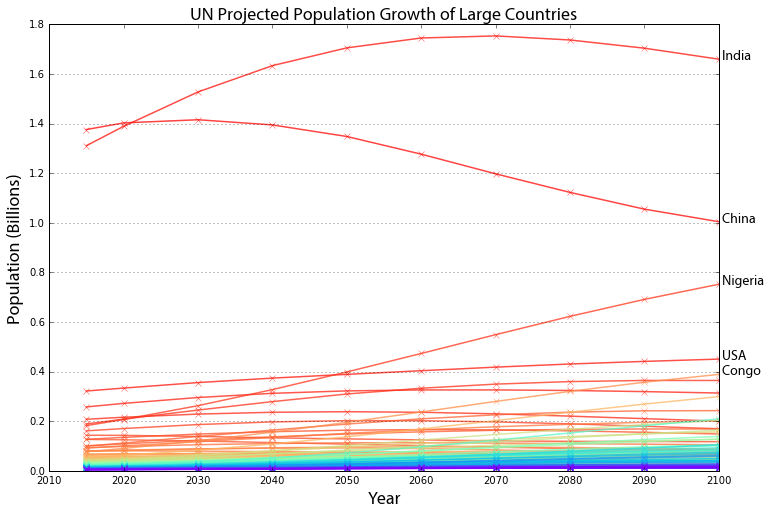

In [10]:
fig, ax = plt.subplots(figsize=[12, 8])
for col, c in reversed(zip(df_plot.columns, color_list)):
    ax.plot(df_plot[col]/10**9, linewidth='1.5', alpha=0.75, marker='x', color=c)
    
ax.set_title('UN Projected Population Growth of Large Countries', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_ylabel('Population (Billions)', fontproperties=label_font)
ax.yaxis.grid()
#ax.set_xlim([2015, 2100])

# annotate the top 5 countries
def annotate(row):
    bbox = dict(boxstyle='round', color='w', fc='w', alpha=0.0)
    name = ' ' + row['country_name']
    pop = row['2100'] / 10**9
    ax.annotate(name, xy=(2100, pop), bbox=bbox, xycoords='data', fontproperties=annot_font)
df['country_name'] = df['country_name'].str.replace('United States of America', 'USA')
df['country_name'] = df['country_name'].str.replace('Democratic Republic of the Congo', 'Congo')
df.sort_values(by='2100', ascending=False).head().apply(annotate, axis=1)

#fig.tight_layout()
fig.savefig('projected-pop-line.png', dpi=300)
plt.show()

## Now, visualize population change with a choropleth map

In [11]:
# calculate the percent change between 2015 and 2100
df['change'] = df['2100'] / df['2015']

In [12]:
# divide up the dataset into quantiles by population change
num_bins = 8
bin_labels = range(num_bins)
df['bin'] = pd.qcut(x=df['change'], q=num_bins, labels=bin_labels)

In [13]:
# create labels and ticks for the legend
def get_label(value):
    pct = int((value - 1) * 100)
    sign = '+' if pct > 0 else ''
    return '{}{:,}%'.format(sign, pct)

# the labels will be the mins of each bin and the max of the last bin
labels = [get_label(df[df['bin']==b]['change'].min()) for b in range(num_bins)]
labels.append(get_label(df[df['bin']==b]['change'].max()))
print labels

# add one more tick mark, for the max of the last bin
label_ticks = bin_labels + [num_bins]
print label_ticks

['-54%', '-28%', '-11%', '+7%', '+23%', '+46%', '+88%', '+231%', '+951%']
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [14]:
# get a list of colors for our choropleth map
color_map = cm.get_cmap('viridis')
skip_colors = 0
increments = [x/float(num_bins + skip_colors) for x in range(num_bins + skip_colors)][skip_colors:]
color_list = color_map(increments).tolist()

C:\Anaconda\lib\site-packages\matplotlib\figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


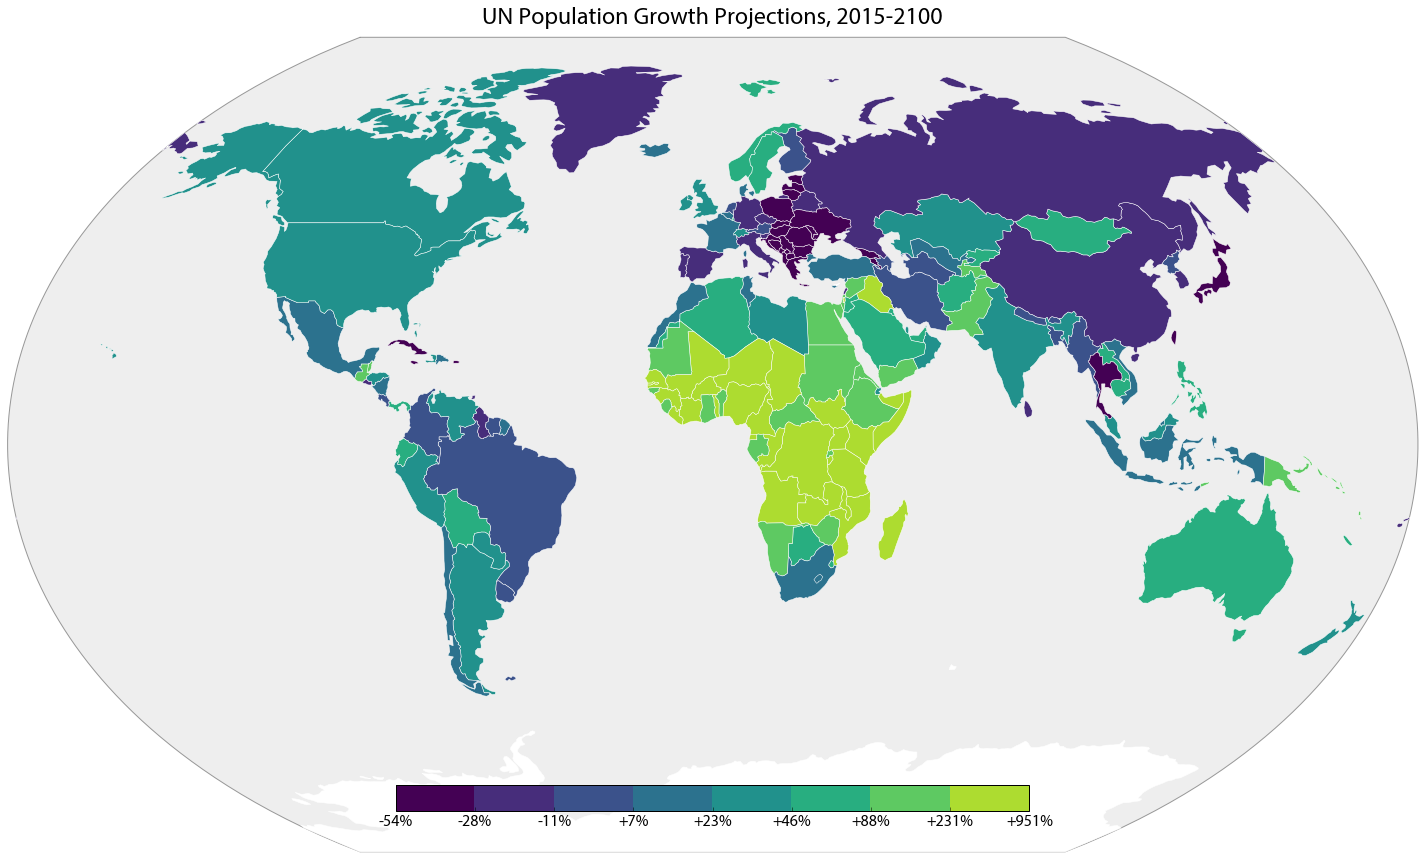

In [15]:
# now create the map: first set up the plotting figure
shapefile = 'countries_110m/ne_110m_admin_0_countries'
fig = plt.figure(figsize=(22, 12))
ax = fig.add_subplot(111, axisbg='#eeeeee', frame_on=False)
ax.set_title('UN Population Growth Projections, 2015-2100', fontproperties=title_font, y=1.01)

# draw the basemap and read the shapefile
m = Basemap(lon_0=0, projection='kav7', resolution=None)
m.drawmapboundary(color='#999999')
m.readshapefile(shapefile, name='shapes', drawbounds=False)

# draw each shape, colored according to bin
for info, shape in zip(m.shapes_info, m.shapes):
    country_code = info['iso_n3']    
    if country_code in df['country_code'].values:
        bin_num = df[df['country_code']==country_code]['bin'].iloc[0]
        color = color_list[bin_num]
    else:
        color = 'w' #if no data
    pc = PatchCollection([Polygon(np.array(shape), True)])
    pc.set_facecolor(color)
    pc.set_edgecolor('w')
    pc.set_linewidth(0.5)
    ax.add_collection(pc)

# draw color legend
legend_width = 0.4
legend_left = (1 - legend_width) / 2.
legend_bottom = 0.06
legend_height = 0.03
ax_legend = fig.add_axes([legend_left, legend_bottom, legend_width, legend_height], zorder=2)
cmap = colors.ListedColormap(color_list)
cb = colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=label_ticks, boundaries=label_ticks, orientation='horizontal')
cb.ax.set_xticklabels(labels, fontproperties=ticks_font)

fig.tight_layout()
fig.savefig('projected-pop-map.png', dpi=300)
plt.show()